In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from tqdm import tqdm
import sep
from astropy.io import fits

In [2]:
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12.0

In [3]:
base = "/home/max/Development/semester-project/"
xdf = "hlsp_xdf_hst_wfc3ir-60mas_hudf_f160w_v1_"
sci_filename = os.path.join(base, "data", xdf+"sci.fits")
wht_filename = os.path.join(base, "data", xdf+"wht.fits")
sci = fits.open(sci_filename)
wht = fits.open(wht_filename)

# Image

In [4]:
image = sci[0].data
image = image.byteswap().newbyteorder()
print('Min:', np.min(image))
print('Max:', np.max(image))
print('Mean:', np.mean(image))
print('Stdev:', np.std(image))

Min: -0.0123764
Max: 87.7352
Mean: 0.000925631
Stdev: 0.0669091


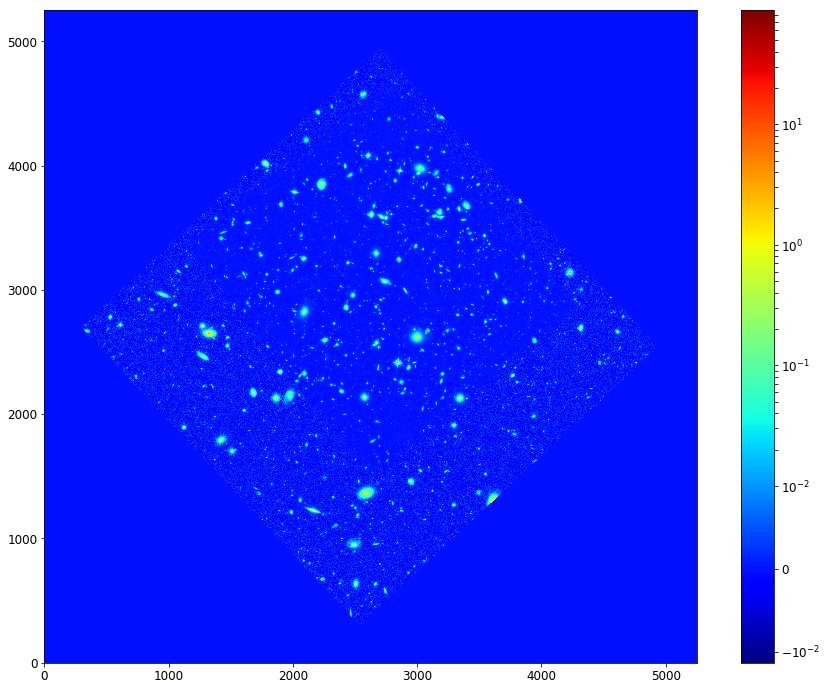

In [5]:
plt.figure(figsize=(16, 12))
plt.imshow(image, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
plt.colorbar()

# Background

In [6]:
background = sep.Background(image)
print("Global mean background: {}".format(background.globalback))
print("Global rms background: {:.5f}".format(background.globalrms))

Global mean background: 0.0
Global rms background: 0.00175


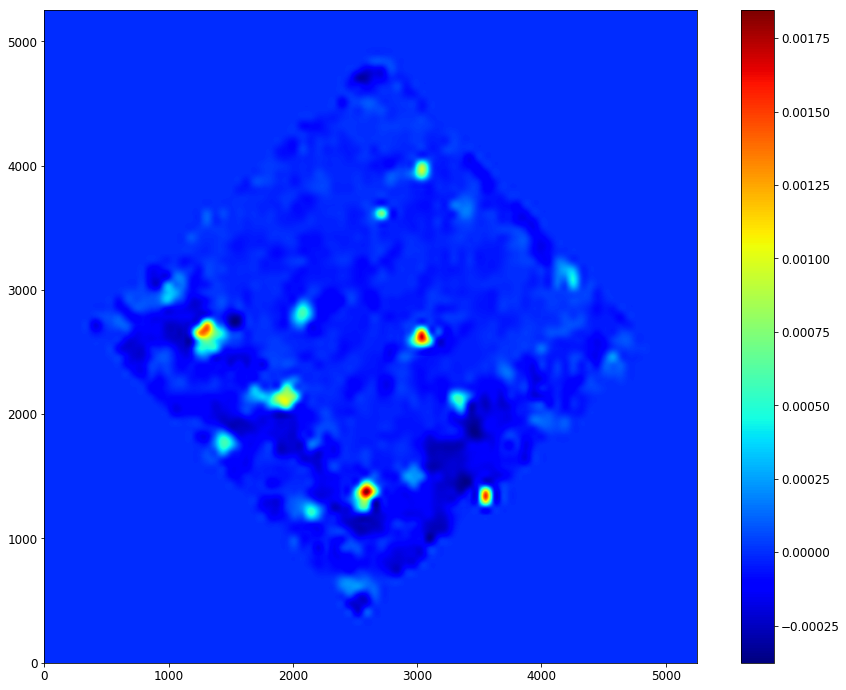

In [7]:
plt.figure(figsize=(16, 12))
plt.imshow(background.back(), interpolation='nearest', cmap='jet', origin='lower')
plt.colorbar()

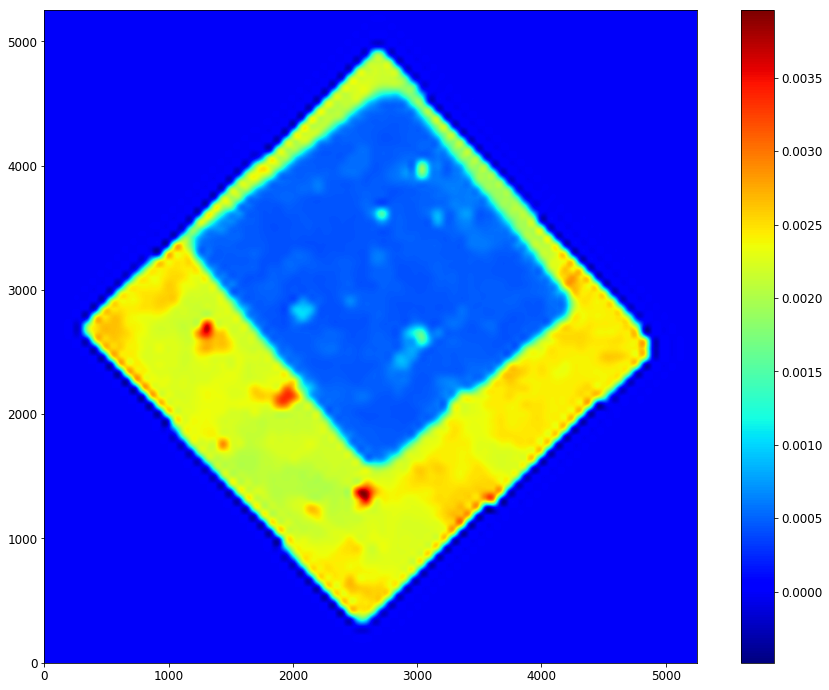

In [8]:
plt.figure(figsize=(16, 12))
plt.imshow(background.rms(), interpolation='nearest', cmap='jet', origin='lower')
plt.colorbar()

# Weight map

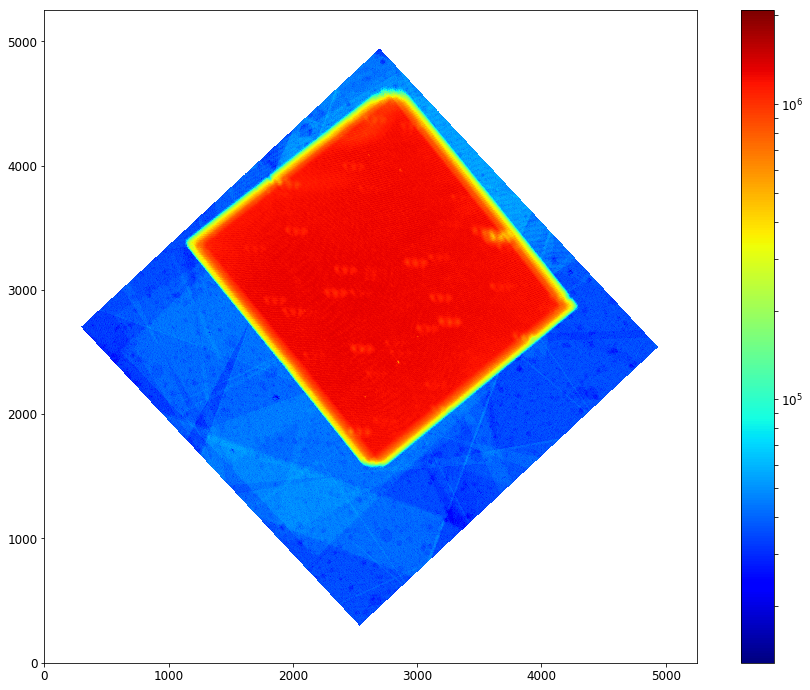

In [9]:
weight = wht[0].data
weight = weight.byteswap().newbyteorder()
plt.figure(figsize=(16, 12))
plt.imshow(weight, interpolation='nearest', cmap='jet', norm=LogNorm(), origin='lower')
plt.colorbar()

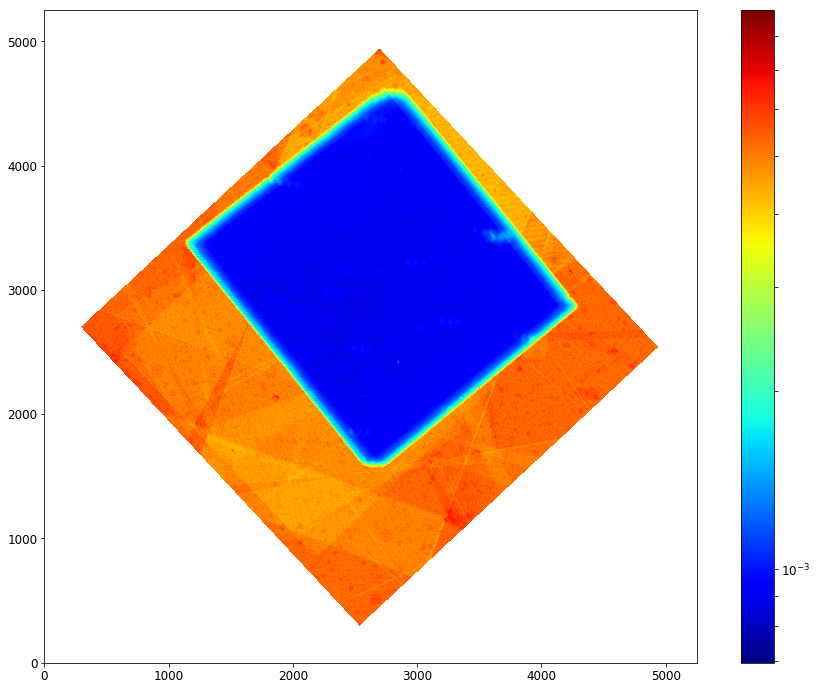

In [10]:
rms = np.zeros_like(weight)
index = (weight > 0)
rms[index] = np.sqrt(1.0/weight[index])

plt.figure(figsize=(16, 12))
plt.imshow(rms, interpolation='nearest', cmap='jet', norm=LogNorm(), origin='lower')
plt.colorbar()

In [11]:
print("Mean rms: {:.5f}".format(np.mean(rms)))

Mean rms: 0.00122


# Detections

Let's look at detections above $1.5\sigma$, with deblending turned off.

In [12]:
%time objects, segmap = sep.extract(image, 1.5, err=rms, deblend_cont=1.0, segmentation_map=True)
print("Number of detections: {}".format(len(objects)))

CPU times: user 2.23 s, sys: 48.1 ms, total: 2.28 s
Wall time: 2.27 s
Number of detections: 3610


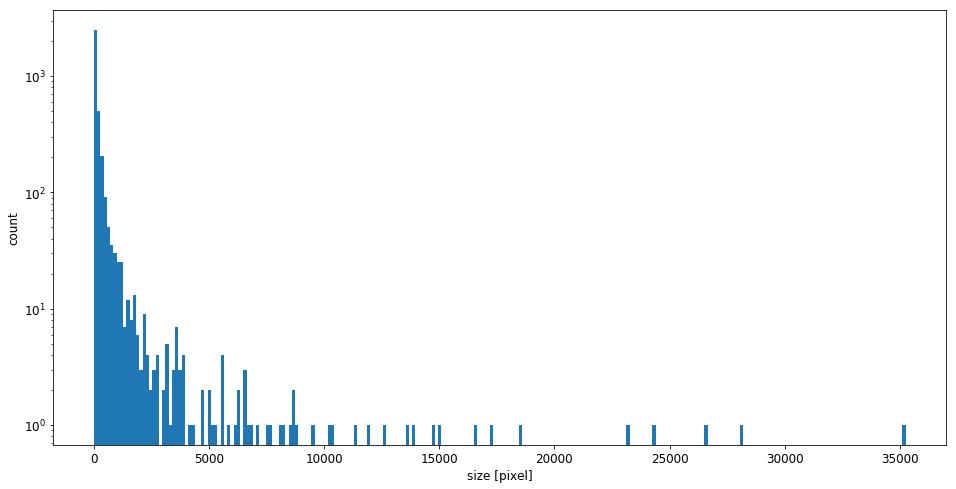

In [13]:
sizes = np.sort([objects[i]['npix'] for i in range(len(objects))])
plt.figure(figsize=(16,8))
plt.xlabel("size [pixel]")
plt.ylabel("count")
histogram = plt.hist(sizes, bins=250, log=True)

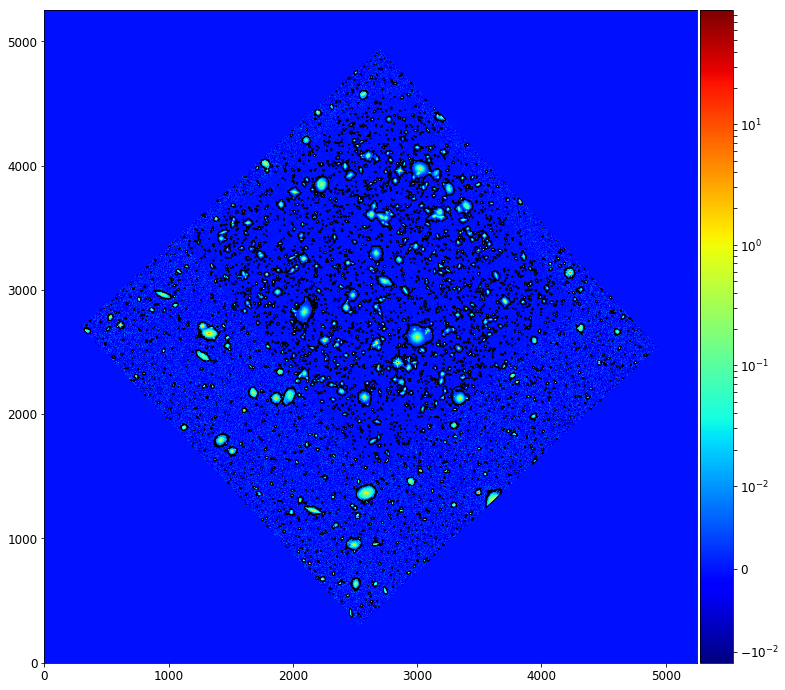

In [14]:
segmap[segmap>0] = 1.0
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.contour(segmap, colors='black', linewidths=0.3)
fig.colorbar(im, cax=cax, orientation='vertical')

## Cutout

In [15]:
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

w = WCS(sci[0].header)
position = (3020, 3470) # star: position = (2950, 2550)
size = (500, 500)
cutout_image = Cutout2D(image, position, size, wcs=w)
cutout_weight = Cutout2D(weight, position, size, wcs=w)
image_1 = np.ascontiguousarray(cutout_image.data)
weight_1 = np.ascontiguousarray(cutout_weight.data)
rms_1 = np.sqrt(1.0/weight_1)

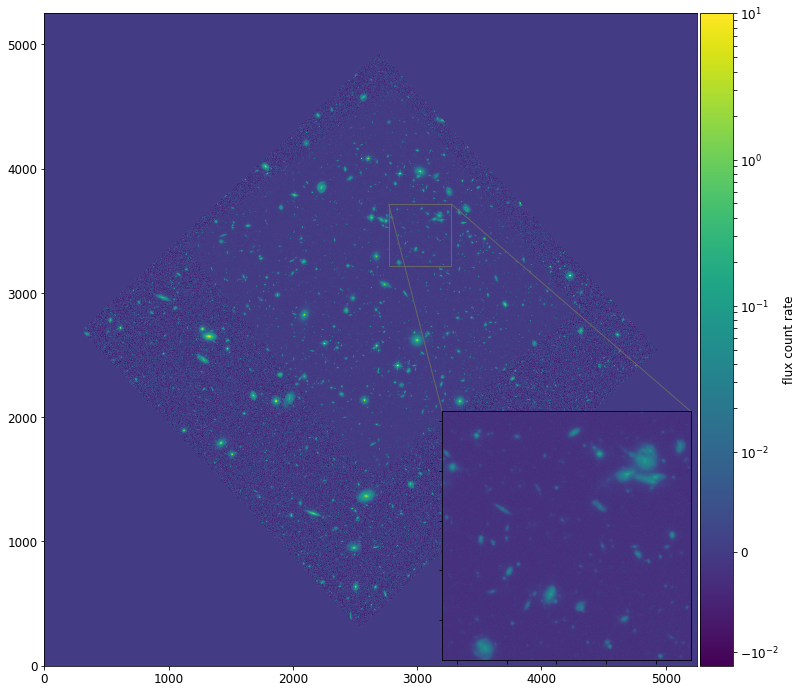

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image, interpolation='nearest', cmap='viridis', norm=SymLogNorm(linthresh=1e-2), vmax=10.0, origin='lower')
axins = zoomed_inset_axes(ax, 4, loc=4)
axins.set_xlim(position[0]-250, position[0]+250)
axins.set_ylim(position[1]-250, position[1]+250)
axins.imshow(image, interpolation='nearest', cmap='viridis', norm=SymLogNorm(linthresh=1e-2), origin='lower')
axins.xaxis.set_major_formatter(plt.NullFormatter())
axins.yaxis.set_major_formatter(plt.NullFormatter())
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec='0.4')
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/xdf.png", bbox_inches='tight')
fig.savefig("images/xdf.pdf", bbox_inches='tight')

# Overshredding

Apart from the detection threshold, that separates background pixels from those possibly belonging to sources, two other main paremeters directly affect the number of sources detected by SExtractor:
1. `NTHRESH`: number of exponential levels considered 
2. `MINCONT`: minimal contrast ratio needed to split an object in two components

Both parameters change the behaviour of the deblending routine.

In [17]:
nthresh = range(32, 1025, 32)
mincont = np.logspace(0, -10, 100)

In [18]:
objects = []
for (i,n) in tqdm(enumerate(nthresh)):
    for (j,m) in enumerate(mincont):
        o = sep.extract(image_1, 1.5, err=rms_1, deblend_nthresh=n, deblend_cont=m)
        objects.append(o)

32it [16:21, 30.66s/it]


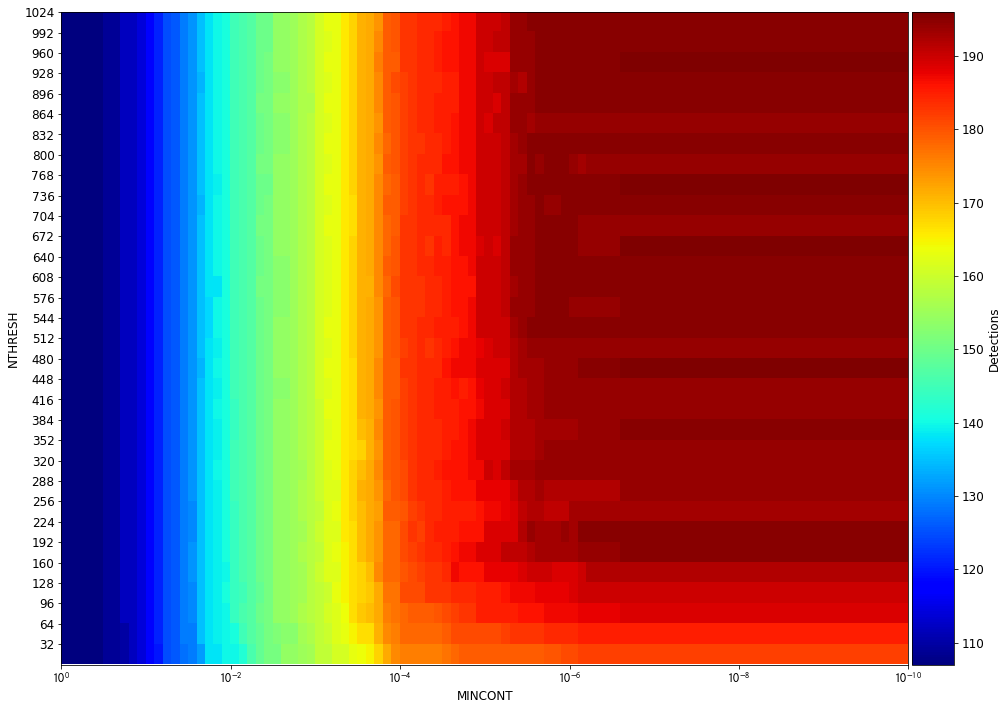

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.set_yticks(nthresh)
ax.set_ylabel("NTHRESH")
ax.set_xlabel("MINCONT")
ax.xaxis.set_major_formatter(plt.FixedFormatter([r'$10^{-10}$', r'$10^{-8}$', r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$']))
detections = np.array([len(o) for o in objects]).reshape(len(nthresh),len(mincont))
im = ax.imshow(detections, interpolation='nearest', cmap='jet', origin='lower', aspect='auto', extent=[0,-10,0,nthresh[-1]])
fig.colorbar(im, cax=cax, orientation='vertical', label="Detections")
fig.savefig("images/mincont-nthresh-grid.png", bbox_inches='tight')
fig.savefig("images/mincont-nthresh-grid.pdf", bbox_inches='tight')

## First moments

Let's have a look at the flux weighted first moments of the detected sources. The barycentre of a source is computed as

$$
r_1 = \frac{\sum r I(r_i)}{\sum I(r_i)}
$$

where $r$ and $I(r)$ are taken within an elliptical aperture of ellipticity $\epsilon$ and angle $\theta$, which has been scaled by $6\sigma_{iso}$. The standard deviation $\sigma_{iso}$ is computed from the second order moments of the object profile and defines an equivalent bivariate gaussian profile.

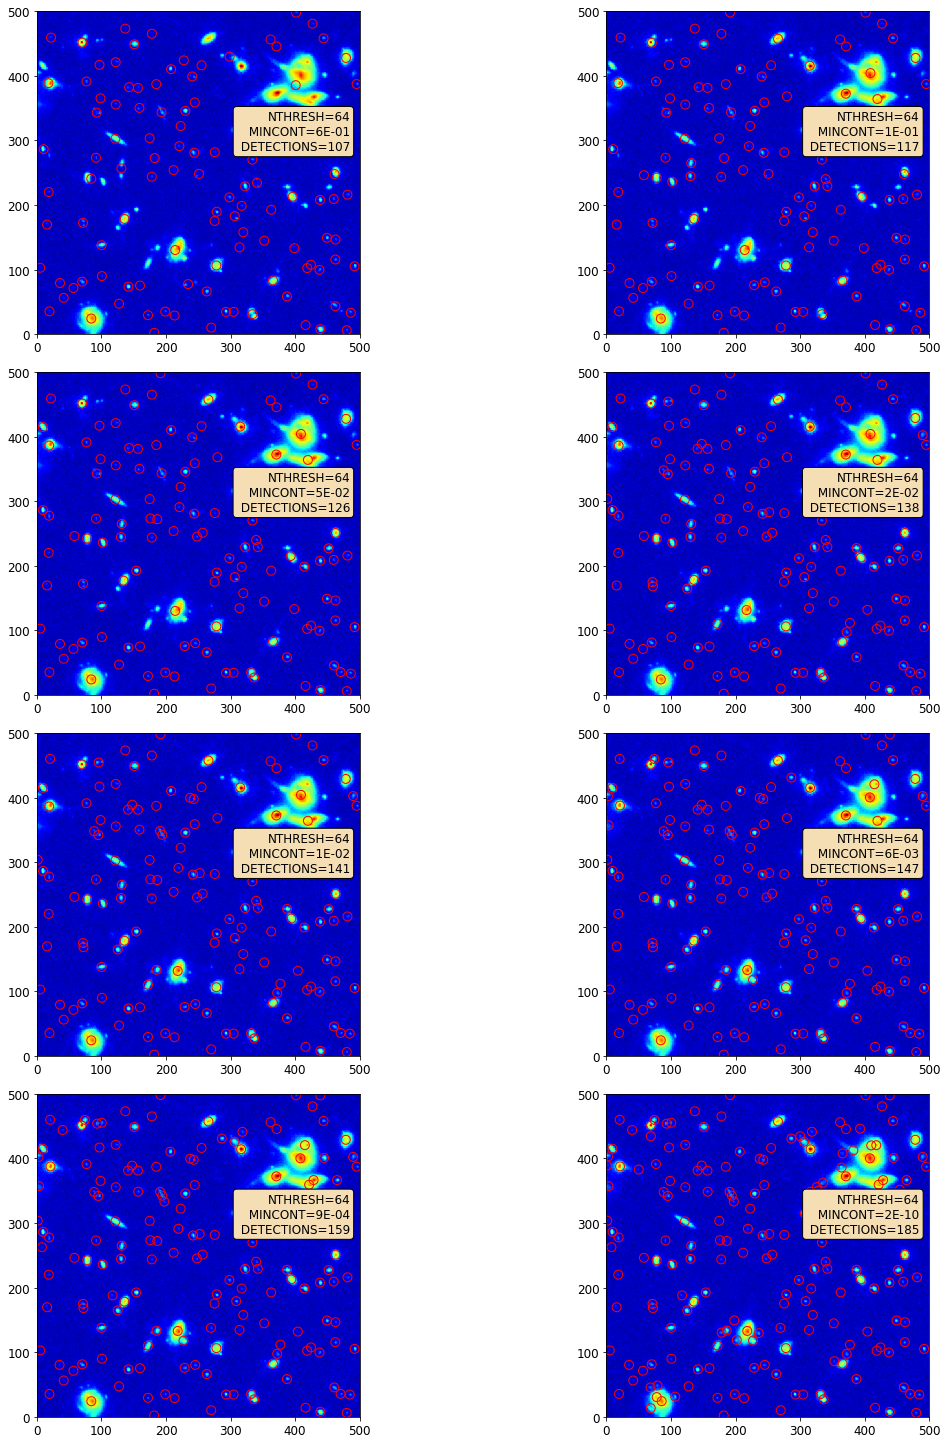

In [20]:
examples = [(2, 1), (10, 1), (13, 1), (17, 1), (20, 1), (22, 1), (30, 1), (97, 1)]
ne = len(examples)
props = dict(boxstyle='round', facecolor='wheat')
fig = plt.figure(figsize=(16, 40))
for (i, ids) in enumerate(examples):
    d = len(objects[ids[1]*100+ids[0]])
    ax = fig.add_subplot(ne, 2, i+1)
    ax.imshow(image_1.data, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower', aspect='equal')
    ax.set_ylim((0,500))
    ax.set_xlim((0,500))
    for o in objects[ids[1]*100+ids[0]]:
        ax.scatter(o['x'], o['y'], s=80, edgecolors='red', facecolors='none')
    ax.text(0.97,0.57, "NTHRESH={}\n MINCONT={:.0E}\n DETECTIONS={}".format(nthresh[ids[1]], mincont[ids[0]], d), transform=ax.transAxes, ha="right", bbox=props)
fig.tight_layout()
fig.savefig("images/first-moments.png", bbox_inches='tight')
fig.savefig("images/first-moments.pdf", bbox_inches='tight')

## Results

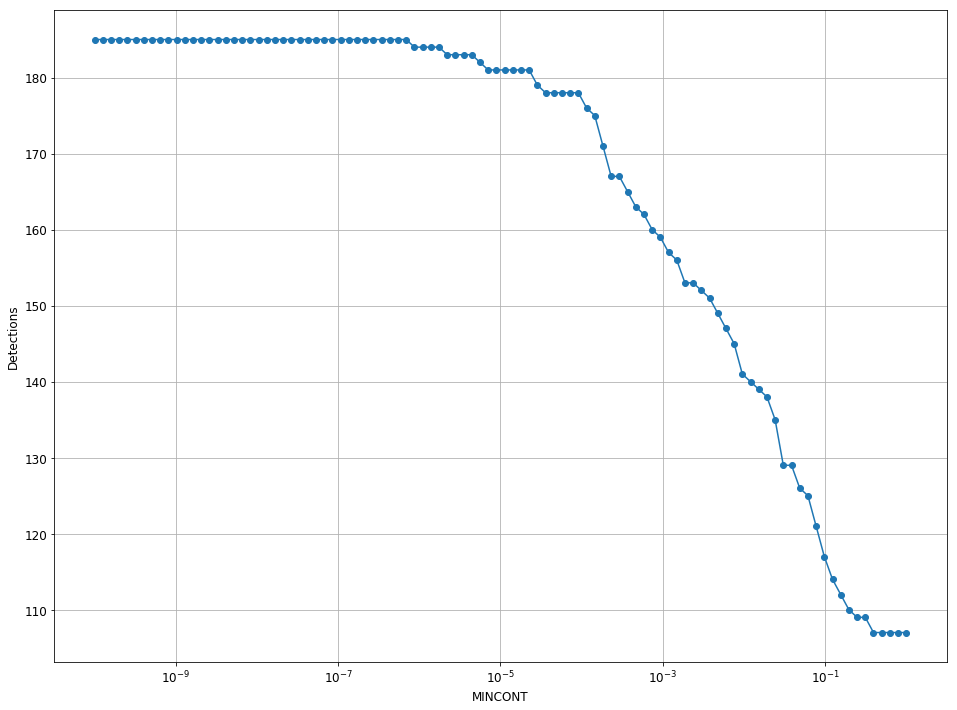

In [21]:
n = 1 # corresponds to 64 levels
detections = np.array([len(objects[n*100+i]) for i in range(len(mincont))])

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_xlabel("MINCONT")
ax.set_ylabel("Detections")
#ax.set_title("NTHRESH=64")
ax.semilogx(mincont, detections, 'o-')
ax.grid(b=True)
fig.savefig("images/detection-vs-mincont.png", bbox_inches='tight')
fig.savefig("images/detection-vs-mincont.pdf", bbox_inches='tight')

To get a sense of how overshredded the source detection is, we look at the fraction of circles of radius $\eta$ placed around the source barycentres which intersect with each other. Below we show an example for a highly overshredded image (`NTHRESH`=64, `MINCONT`=2E-10)

(0, 500)

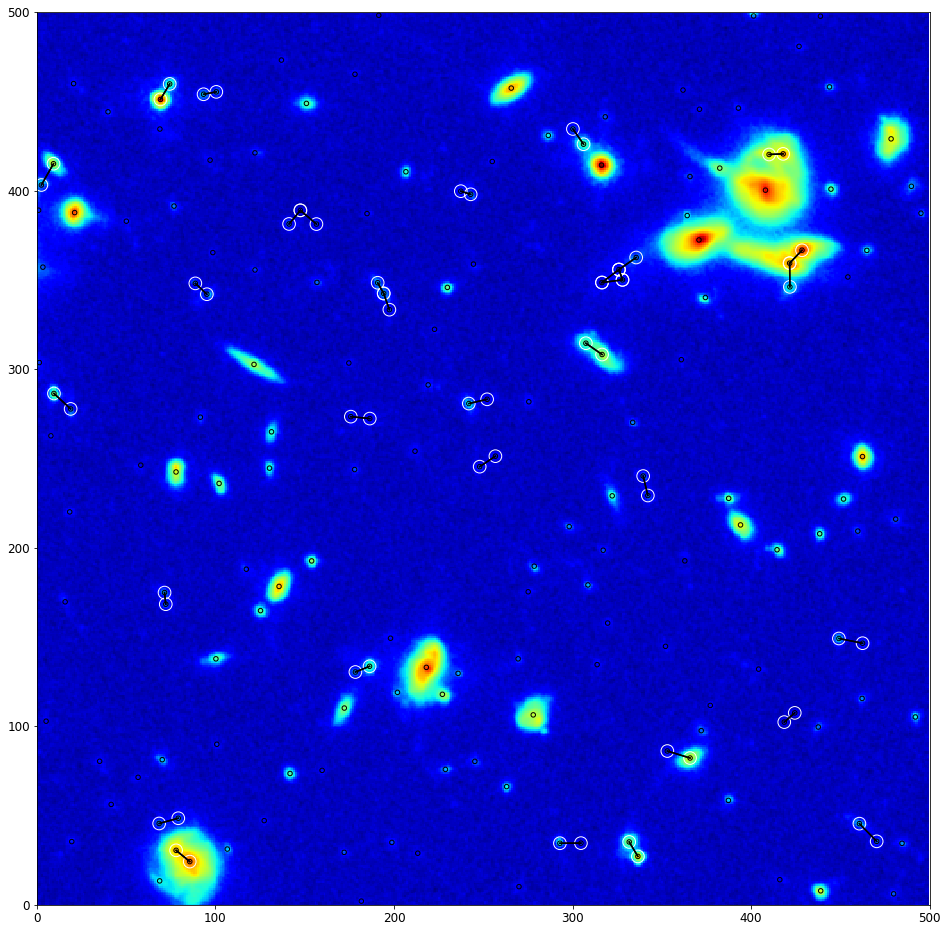

In [22]:
from matplotlib.lines import Line2D
def find_intersections(objects, ws=5):
    detections = len(objects)
    barycentres = np.zeros((detections, 2))
    for (i, s) in enumerate(objects):
        barycentres[i, :] = [s['x'], s['y']]
    intersections = []
    lines = []
    for i in range(detections):
        for j in range(detections):
            if i != j:
                flag = (barycentres[i,0]-barycentres[j,0])**2+(barycentres[i,1]-barycentres[j,1])**2 <= 4*ws**2
                if flag:
                    intersections.append((barycentres[i, :], barycentres[j, :]))
                    lines.append(Line2D([barycentres[i,0], barycentres[j,0]], [barycentres[i,1], barycentres[j,1]], color='black'))
    return intersections, lines, barycentres

intersections, lines, barycentres = find_intersections(objects[n*100+97], ws=7)
fig, ax = plt.subplots(1, 1, figsize=(16, 40))
ax.imshow(image_1.data, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower', aspect='equal')
for pair in intersections:
    ax.scatter(pair[0][0], pair[0][1], s=160, edgecolors='white', facecolors='none')
    #ax.scatter(pair[1][0], pair[1][1], s=80, edgecolors='red', facecolors='none')
for line in lines:
    ax.add_line(line)
for point in barycentres:
    ax.scatter(point[0], point[1], s=20, edgecolors='black', facecolors='none')
ax.set_ylim((0,500))
ax.set_xlim((0,500))

In [23]:
overshredding = np.zeros(len(objects))
for (i, objs) in tqdm(enumerate(objects)):
    intersections, _, _ = find_intersections(objs, ws=7)
    overshredding[i] = len(intersections)/(2.0*len(objs))
overshredding = overshredding.reshape((len(nthresh), len(mincont)))

3200it [03:41, 14.47it/s]


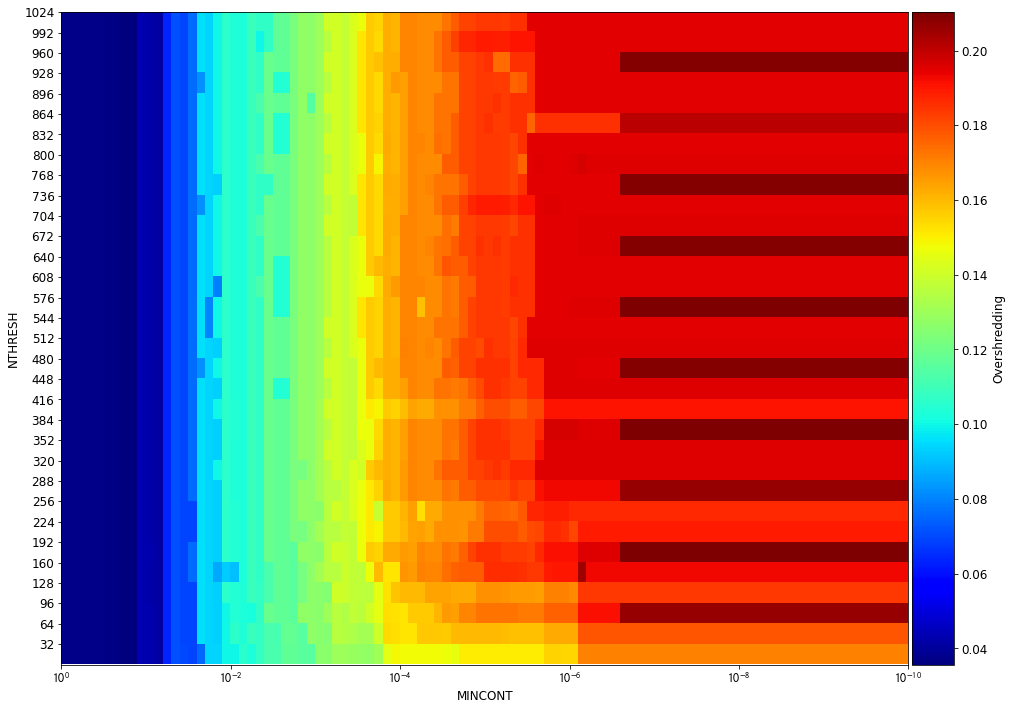

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.set_yticks(nthresh)
ax.set_ylabel("NTHRESH")
ax.set_xlabel("MINCONT")
ax.xaxis.set_major_formatter(plt.FixedFormatter([r'$10^{-10}$', r'$10^{-8}$', r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$']))
im = ax.imshow(overshredding, interpolation='nearest', cmap='jet', origin='lower', aspect='auto', extent=[0,-10,0,nthresh[-1]])
fig.colorbar(im, cax=cax, orientation='vertical', label="Overshredding")

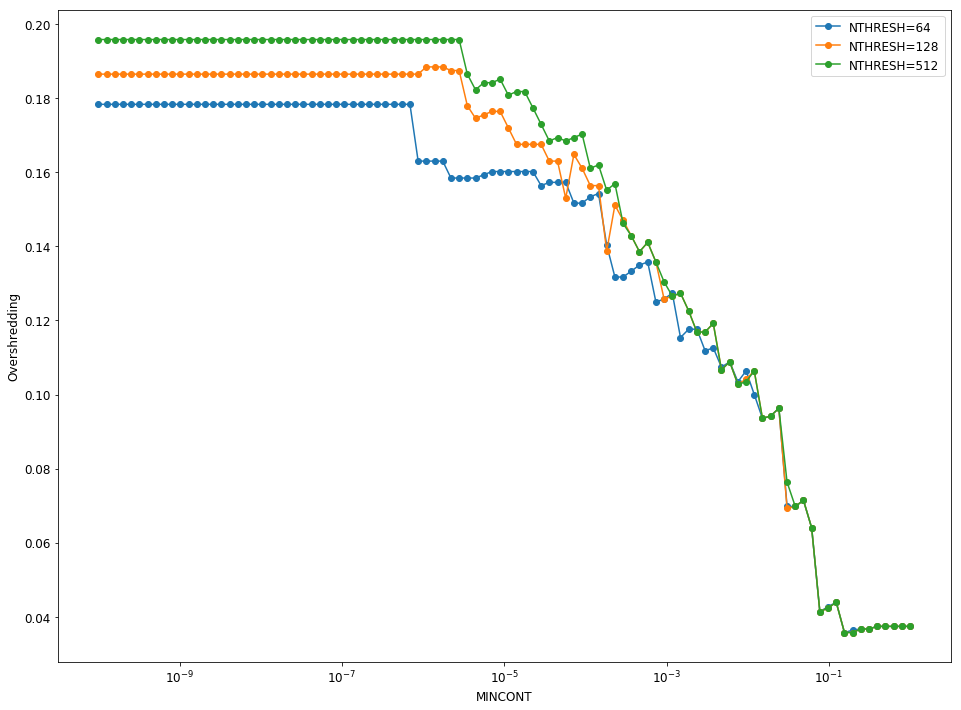

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_xlabel("MINCONT")
ax.set_ylabel("Overshredding")
ax.semilogx(mincont, overshredding[1, :], 'o-', label="NTHRESH=64")
ax.semilogx(mincont, overshredding[7, :], 'o-', label="NTHRESH=128")
ax.semilogx(mincont, overshredding[15, :], 'o-', label="NTHRESH=512")
ax.legend(loc="upper right")

# Conclusions

Achieving overshredding can be done by setting a low deblending contrast ratio, defined by the parameter `MINCONT`. This parameter drives the behaviour until saturation is achieved at about $10^{-7}$. Below this critcical value of `MINCONT`, the overshredding is driven by `NTHRESH`, the number of exponential levels considered during the deblending routine. Incresing it makes the algorithm more sensitive to smaller structures.